In [1]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from matplotlib.patches import Ellipse

from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from heatmap import generate_heatmap

In [2]:
image_path = './images/Cookie_theft_segmentation.png'
image = cv2.imread(image_path)

# Convert the image to RGB (OpenCV loads images in BGR format by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixels = image_rgb.reshape(-1, 3)

# Use a KD-Tree to find unique colors within a threshold
threshold = 5
tree = cKDTree(pixels)
unique_colors = []
labels = np.zeros(pixels.shape[0], dtype=int) - 1

for i, pixel in enumerate(pixels):
    if labels[i] == -1:
        indices = tree.query_ball_point(pixel, threshold)
        unique_colors.append(pixel)
        labels[indices] = len(unique_colors) - 1

unique_colors = np.array(unique_colors)

# Print unique colors
print(f"Unique colors (within threshold): {unique_colors}")

Unique colors (within threshold): [[  0   0   0]
 [255   0   0]
 [  0   0 255]
 [128   0   0]
 [255 255   0]
 [  0 255 255]
 [128 128   0]
 [255   0 255]
 [  0   0 128]
 [  0 255   0]
 [  0 128   0]]


In [3]:
# Create a dictionary mapping from color tuples to segment labels
color_to_label = {tuple(color): label for label, color in enumerate(unique_colors)}

# Print the mapping
print(f"Color to label mapping: {color_to_label}")


Color to label mapping: {(0, 0, 0): 0, (255, 0, 0): 1, (0, 0, 255): 2, (128, 0, 0): 3, (255, 255, 0): 4, (0, 255, 255): 5, (128, 128, 0): 6, (255, 0, 255): 7, (0, 0, 128): 8, (0, 255, 0): 9, (0, 128, 0): 10}


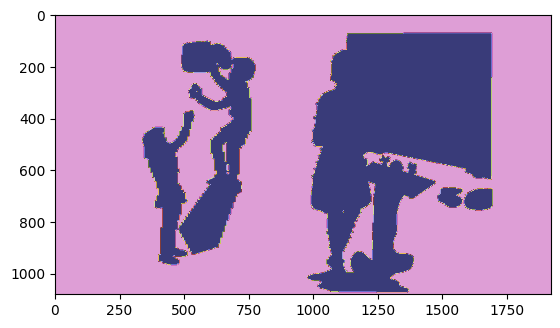

0


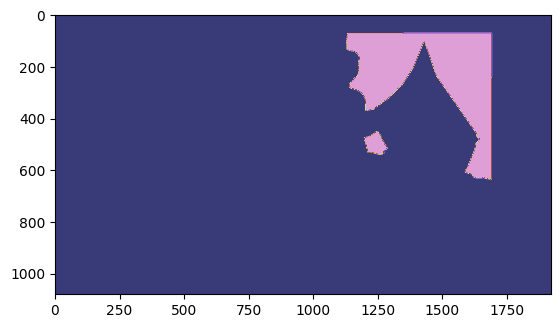

1


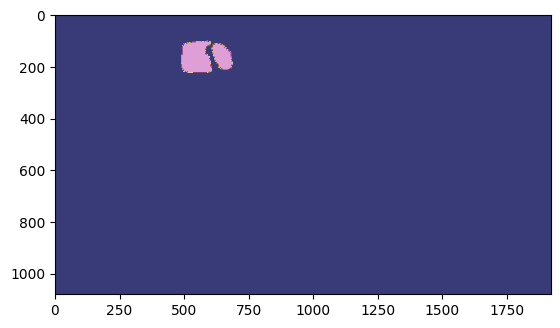

2


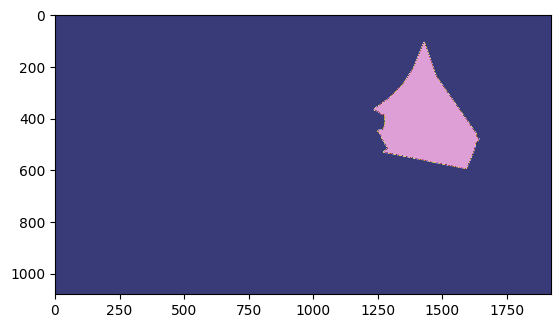

3


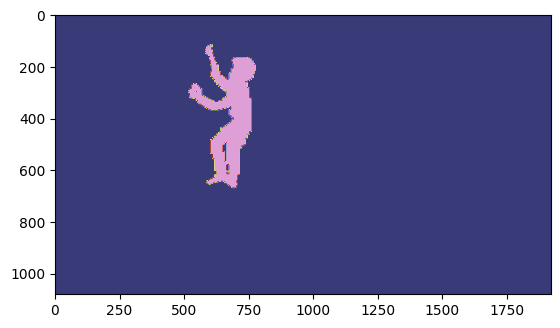

4


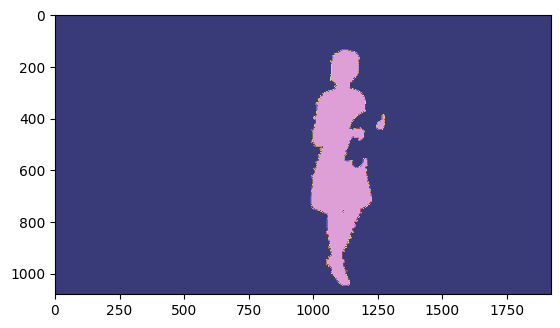

5


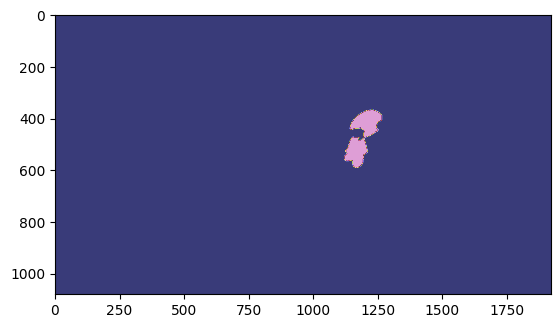

6


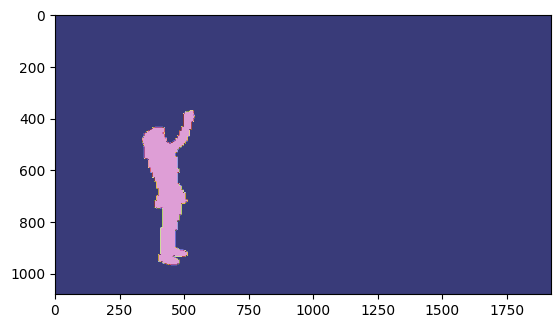

7


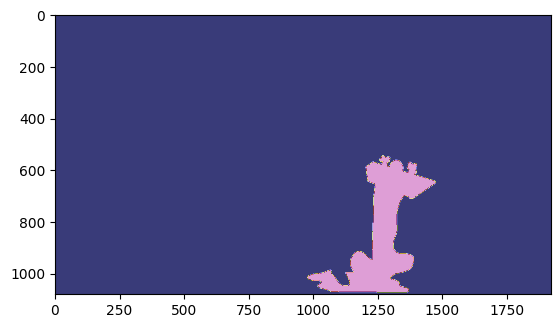

8


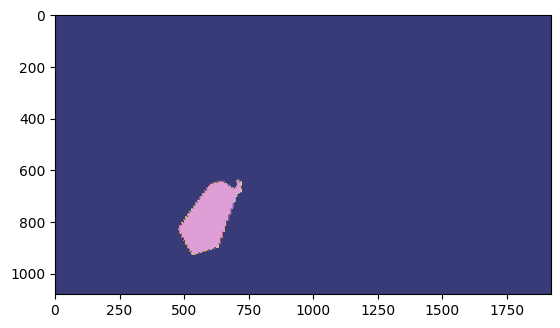

9


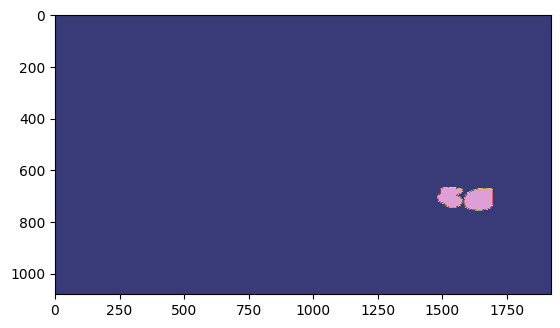

10
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
# Initialize the segmented mask with the same height and width as the input image
segmented_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=np.int32)

# Assign labels to each pixel based on the color
for i, color in enumerate(unique_colors):
    mask = np.all(image_rgb==color, axis=-1)
    plt.imshow(mask, cmap='tab20b')
    plt.show()
    print(i)
    segmented_mask[mask] = i

# Print the segmented mask
print(segmented_mask)


In [5]:
# for id in mask_id_list:
#     isolated_mask = segmented_mask.copy()
#     isolated_mask[isolated_mask != id] = -1
#     print(f"id: {id}, tag: {image_component_id_lookup[id]}")
#     print(np.unique(isolated_mask))
#     seperated_masks[id] = isolated_mask
#     plt.imshow(seperated_masks[id], cmap='nipy_spectral')
#     plt.colorbar()
#     plt.show()

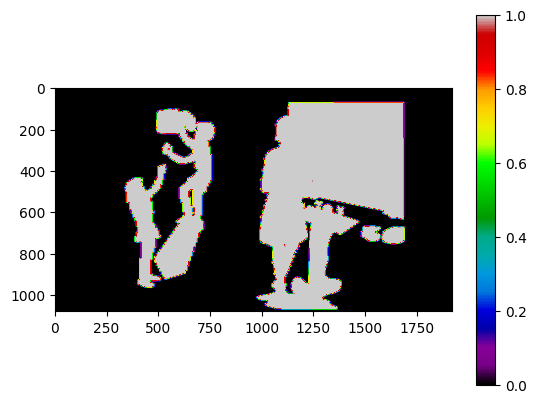

In [6]:
image_component_mask = segmented_mask.copy().astype(float)
image_component_mask[image_component_mask != 0] = 1.0 # Put 1 here so it is normalized
plt.imshow(image_component_mask, cmap='nipy_spectral')
plt.colorbar()
plt.show()

In [7]:
# Make 0 values transparent in heatmap
hot_cmap = plt.get_cmap('plasma')  # Get the original 'hot' colormap
hot_colors = hot_cmap(np.arange(hot_cmap.N))  # Get the colormap colors
hot_colors[:, -1] = np.linspace(0, 1, hot_cmap.N)  # Modify alpha values
hot_cmap_with_alpha = LinearSegmentedColormap.from_list('hot_alpha', hot_colors)

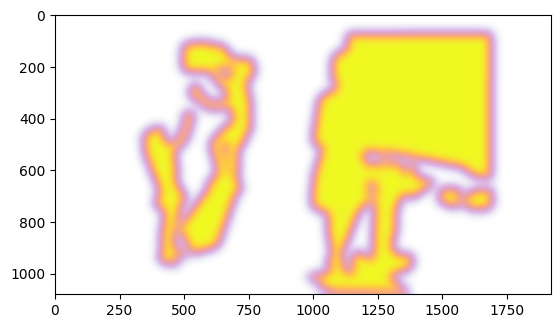

In [8]:
sigma = 20
baseline = gaussian_filter(image_component_mask, sigma=sigma)
plt.imshow(baseline, cmap=hot_cmap_with_alpha, alpha=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


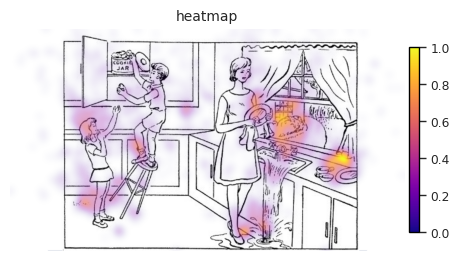

In [9]:
p23_s1_distribution = generate_heatmap("./data/P23_S1_all_gaze.csv", sigma=sigma, is_saving=False, height=1080, width=1920)

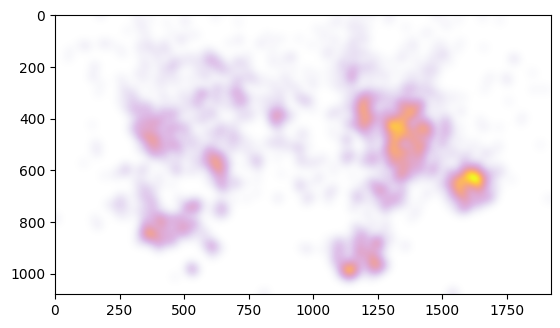

In [10]:
plt.imshow(p23_s1_distribution, cmap=hot_cmap_with_alpha, alpha=1)

In [11]:
p23_s1_distribution.shape

(1080, 1920)

In [12]:
baseline.shape

(1080, 1920)

In [13]:
baseline

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## MSE

In [14]:
def mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

similarity_score = mse(baseline, p23_s1_distribution)
print("Mean Squared Error:", similarity_score)


Mean Squared Error: 0.19650831562773202


## Structural Similarity Index 

In [15]:
from skimage.metrics import structural_similarity as ssim

def compute_ssim(image1, image2):
    score, _ = ssim(image1, image2, full=True, data_range=1.0)
    return score

similarity_score = compute_ssim(baseline, p23_s1_distribution)
print("SSIM:", similarity_score)


SSIM: 0.46679432532794196


P02 S1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


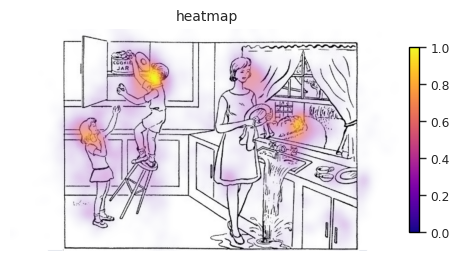

Mean Squared Error: 0.1873491385559994
SSIM: 0.47116050966696843
P02 S2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[[2.43535800e-05 1.62847175e-05 1.97662728e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.43204457e-05 1.62625613e-05 1.97393798e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.42542495e-05 1.62182973e-05 1.96856525e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


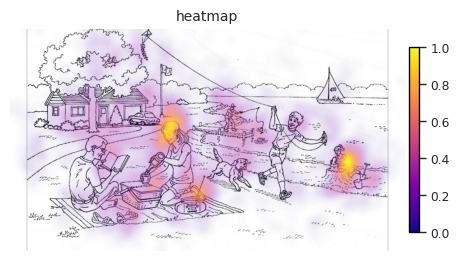

Mean Squared Error: 0.20372138011287952
SSIM: 0.34020748279471363
P02 S3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00883211 0.00881238 0.00877306 ... 0.         0.         0.        ]
 [0.00877459 0.008755   0.00871593 ... 0.         0.         0.        ]
 [0.00874569 0.00872615 0.00868722 ... 0.         0.         0.        ]]


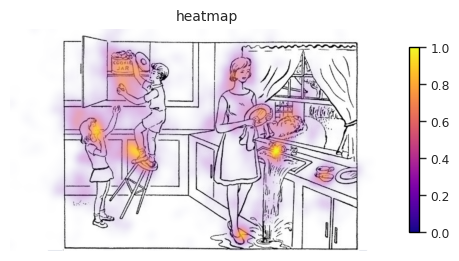

Mean Squared Error: 0.1878238910098171
SSIM: 0.464050412937097
P02 S4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


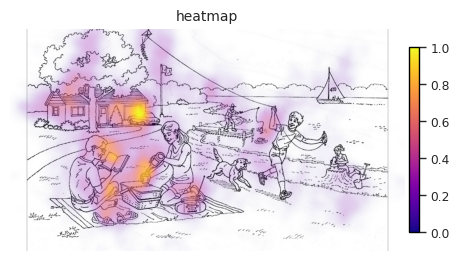

Mean Squared Error: 0.21004439153196738
SSIM: 0.34323896635723045
P02 S5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


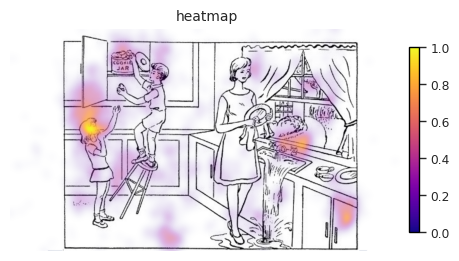

Mean Squared Error: 0.22057499809321085
SSIM: 0.41936517755516584


In [17]:
mse_list = [[], []]
ssim_list = [[], []]

print("P02 S1")
partic_distribution = generate_heatmap("./data/P02_S1_all_gaze.csv", sigma=sigma, is_saving=False, height=1080, width=1920)
similarity_score = mse(baseline, partic_distribution)
mse_list[0].append(similarity_score)
print("Mean Squared Error:", similarity_score)
similarity_score = compute_ssim(baseline, partic_distribution)
ssim_list[0].append(similarity_score)
print("SSIM:", similarity_score)

print("P02 S2")
partic_distribution = generate_heatmap("./data/P02_S2_all_gaze.csv", sigma=sigma, is_saving=False, height=1080, width=1920)
similarity_score = mse(baseline, partic_distribution)
mse_list[0].append(similarity_score)
print("Mean Squared Error:", similarity_score)
similarity_score = compute_ssim(baseline, partic_distribution)
ssim_list[0].append(similarity_score)
print("SSIM:", similarity_score)

print("P02 S3")
partic_distribution = generate_heatmap("./data/P02_S3_all_gaze.csv", sigma=sigma, is_saving=False, height=1080, width=1920)
similarity_score = mse(baseline, partic_distribution)
mse_list[0].append(similarity_score)
print("Mean Squared Error:", similarity_score)
similarity_score = compute_ssim(baseline, partic_distribution)
ssim_list[0].append(similarity_score)
print("SSIM:", similarity_score)

print("P02 S4")
partic_distribution = generate_heatmap("./data/P02_S4_all_gaze.csv", sigma=sigma, is_saving=False, height=1080, width=1920)
similarity_score = mse(baseline, partic_distribution)
mse_list[0].append(similarity_score)
print("Mean Squared Error:", similarity_score)
similarity_score = compute_ssim(baseline, partic_distribution)
ssim_list[0].append(similarity_score)
print("SSIM:", similarity_score)

print("P02 S5")
partic_distribution = generate_heatmap("./data/P02_S5 # Partial_all_gaze.csv", sigma=sigma, is_saving=False, height=1080, width=1920)
similarity_score = mse(baseline, partic_distribution)
mse_list[0].append(similarity_score)
print("Mean Squared Error:", similarity_score)
similarity_score = compute_ssim(baseline, partic_distribution)
ssim_list[0].append(similarity_score)
print("SSIM:", similarity_score)


P07 S1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.30589419e-06 1.34917983e-06 1.43673399e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.26902655e-06 1.31109016e-06 1.39617251e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.25062812e-06 1.29208189e-06 1.37593071e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


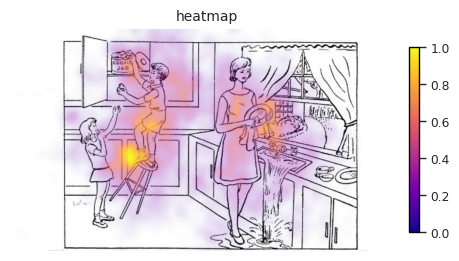

Mean Squared Error: 0.17023477681836133
SSIM: 0.4694485297938191
P07 S2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.01680183 0.01677985 0.01676881]
 [0.         0.         0.         ... 0.01666479 0.01664295 0.01663198]
 [0.         0.         0.         ... 0.016596   0.01657423 0.0165633 ]]


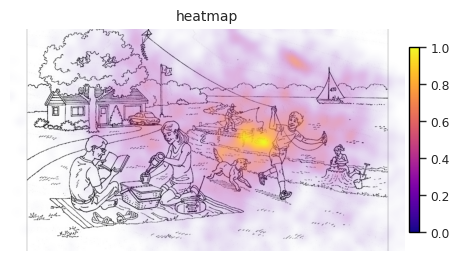

Mean Squared Error: 0.13250949972063
SSIM: 0.3673598803519682
P07 S3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[[0.00323321 0.00325841 0.00330878 ... 0.         0.         0.        ]
 [0.00323614 0.00326135 0.00331173 ... 0.         0.         0.        ]
 [0.00324126 0.00326648 0.00331689 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


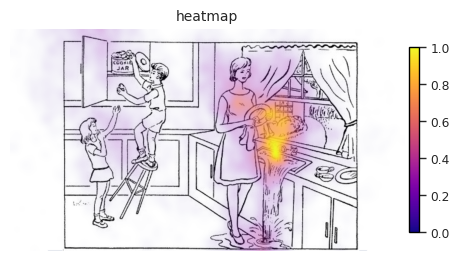

Mean Squared Error: 0.1729200277154033
SSIM: 0.42568647285109806
P07 S4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[[3.06475445e-06 3.14436468e-06 3.30481515e-06 ... 1.53579742e-03
  1.50581600e-03 1.49081831e-03]
 [3.10397857e-06 3.18460768e-06 3.34711167e-06 ... 1.53469747e-03
  1.50476325e-03 1.48978916e-03]
 [3.18249788e-06 3.26516661e-06 3.43178136e-06 ... 1.52735785e-03
  1.49749406e-03 1.48255512e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


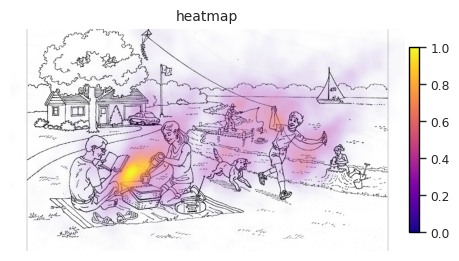

Mean Squared Error: 0.1765751152056885
SSIM: 0.4471370708537758
P07 S5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[[1.26176221e-01 1.26204986e-01 1.26262652e-01 ... 1.83783102e-02
  1.82586296e-02 1.81984749e-02]
 [1.25994932e-01 1.26023573e-01 1.26080990e-01 ... 1.83372628e-02
  1.82178495e-02 1.81578292e-02]
 [1.25632964e-01 1.25661359e-01 1.25718282e-01 ... 1.82554404e-02
  1.81365599e-02 1.80768074e-02]
 ...
 [3.92799084e-04 4.02348050e-04 4.21577337e-04 ... 4.82509100e-06
  4.74269376e-06 4.70144052e-06]
 [3.93263733e-04 4.02823995e-04 4.22076029e-04 ... 6.19701922e-06
  6.09119380e-06 6.03821094e-06]
 [3.93494828e-04 4.03060709e-04 4.22324056e-04 ... 5.98142197e-06
  5.87927826e-06 5.82813870e-06]]


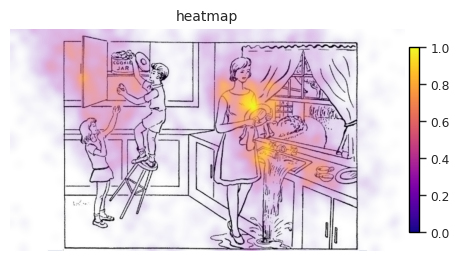

Mean Squared Error: 0.14939012921597328
SSIM: 0.35618200949405104


In [20]:

print("P07 S1")
partic_distribution = generate_heatmap("./data/P07_S1_all_gaze.csv", sigma=sigma, is_saving=False, height=1080, width=1920)
similarity_score = mse(baseline, partic_distribution)
mse_list[1].append(similarity_score)
print("Mean Squared Error:", similarity_score)
similarity_score = compute_ssim(baseline, partic_distribution)
ssim_list[1].append(similarity_score)
print("SSIM:", similarity_score)

print("P07 S2")
partic_distribution = generate_heatmap("./data/P07_S2_all_gaze.csv", sigma=sigma, is_saving=False, height=1080, width=1920)
similarity_score = mse(baseline, partic_distribution)
mse_list[1].append(similarity_score)
print("Mean Squared Error:", similarity_score)
similarity_score = compute_ssim(baseline, partic_distribution)
ssim_list[1].append(similarity_score)
print("SSIM:", similarity_score)

print("P07 S3")
partic_distribution = generate_heatmap("./data/P07_S3_all_gaze.csv", sigma=sigma, is_saving=False, height=1080, width=1920)
similarity_score = mse(baseline, partic_distribution)
mse_list[1].append(similarity_score)
print("Mean Squared Error:", similarity_score)
similarity_score = compute_ssim(baseline, partic_distribution)
ssim_list[1].append(similarity_score)
print("SSIM:", similarity_score)

print("P07 S4")
partic_distribution = generate_heatmap("./data/P07_S4_all_gaze.csv", sigma=sigma, is_saving=False, height=1080, width=1920)
similarity_score = mse(baseline, partic_distribution)
mse_list[1].append(similarity_score)
print("Mean Squared Error:", similarity_score)
similarity_score = compute_ssim(baseline, partic_distribution)
ssim_list[1].append(similarity_score)
print("SSIM:", similarity_score)

print("P07 S5")
partic_distribution = generate_heatmap("./data/P07_S5_all_gaze.csv", sigma=sigma, is_saving=False, height=1080, width=1920)
similarity_score = mse(baseline, partic_distribution)
mse_list[1].append(similarity_score)
print("Mean Squared Error:", similarity_score)
similarity_score = compute_ssim(baseline, partic_distribution)
ssim_list[1].append(similarity_score)
print("SSIM:", similarity_score)

In [22]:
print("P02 MSE")
print(f"S1: {mse_list[0][0]}")
print(f"S3: {mse_list[0][2]}")
print(f"S5: {mse_list[0][4]}")

print(f"S2: {mse_list[0][1]}")
print(f"S4: {mse_list[0][3]}")

print("P07 MSE")
print(f"S1: {mse_list[1][0]}")
print(f"S3: {mse_list[1][2]}")
print(f"S5: {mse_list[1][4]}")

print(f"S2: {mse_list[1][1]}")
print(f"S4: {mse_list[1][3]}")

P02 MSE
S1: 0.1873491385559994
S3: 0.1878238910098171
S5: 0.22057499809321085
S2: 0.20372138011287952
S4: 0.21004439153196738
P07 MSE
S1: 0.17023477681836133
S3: 0.1729200277154033
S5: 0.14939012921597328
S2: 0.13250949972063
S4: 0.1765751152056885


In [25]:
print("P02 SSIM")
print(f"S1: {ssim_list[0][0]}")
print(f"S3: {ssim_list[0][2]}")
print(f"S5: {ssim_list[0][4]}")

print(f"S2: {ssim_list[0][1]}")
print(f"S4: {ssim_list[0][3]}")

print("P07 SSIM")
print(f"S1: {ssim_list[1][0]}")
print(f"S3: {ssim_list[1][2]}")
print(f"S5: {ssim_list[1][4]}")

print(f"S2: {ssim_list[1][1]}")
print(f"S4: {ssim_list[1][3]}")

P02 SSIM
S1: 0.47116050966696843
S3: 0.464050412937097
S5: 0.41936517755516584
S2: 0.34020748279471363
S4: 0.34323896635723045
P07 SSIM
S1: 0.4694485297938191
S3: 0.42568647285109806
S5: 0.35618200949405104
S2: 0.3673598803519682
S4: 0.4471370708537758


## Historgram Comparison

In [24]:
from scipy.stats import entropy

def compare_histograms(image1, image2, bins=256):
    hist1, _ = np.histogram(image1, bins=bins, range=(0, 1), density=True)
    hist2, _ = np.histogram(image2, bins=bins, range=(0, 1), density=True)
    return entropy(hist1, hist2)

similarity_score = compare_histograms(baseline, p23_s1_distribution)
print("Histogram KL Divergence:", similarity_score)


Histogram KL Divergence: 1.6873588253889573


## Normalized Cross-Correlation

In [ ]:
from scipy.signal import correlate2d

def normalized_cross_correlation(image1, image2):
    image1 = (image1 - np.mean(image1)) / (np.std(image1) * len(image1))
    image2 = (image2 - np.mean(image2)) / np.std(image2)
    return correlate2d(image1, image2, mode='same').max()

similarity_score = normalized_cross_correlation(baseline, p23_s1_distribution)
print("Normalized Cross-Correlation:", similarity_score)
